# ML lab 04: Hyperparameter optimization

## Grid search vs. random search vs. other strategies


### Example with ElasticNet Regression

ElasticNet regression is a machine learning model that combines the principles of **Ridge** and **Lasso** regression. It is a linear regression model that regularizes the coefficients of the features by adding a penalty to the cost function. The goal is to improve the model's generalization ability by preventing overfitting, especially when dealing with many correlated features or when the number of features exceeds the number of observations.

### Key Concepts

1. **Ridge Regression (L2 Regularization)**
   - Adds a penalty proportional to the square of the magnitude of the coefficients (L2 norm).
   - Shrinks coefficients but does not set them exactly to zero.
   - Objective function:    $$\text{Cost} = \text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2$$

2. **Lasso Regression (L1 Regularization)**
   - Adds a penalty proportional to the absolute value of the coefficients (L1 norm).
   - Shrinks some coefficients exactly to zero, making it useful for feature selection.
   - Objective function: $$\text{Cost} = \text{RSS} + \lambda \sum_{j=1}^{p} |\beta_j|$$

3. **ElasticNet Regression**
   - Combines L1 (Lasso) and L2 (Ridge) regularization.
   - Useful when features are highly correlated.
   - Objective function: $$\text{Cost} = \text{RSS} + \lambda \left( \alpha \sum_{j=1}^{p} |\beta_j| + (1 - \alpha) \sum_{j=1}^{p} \beta_j^2 \right)$$
   - The parameter $\alpha$ (`l1_ratio` in scikit-learn) controls the balance between Lasso and Ridge:
     - $\alpha = 1$: Equivalent to _Lasso_
     - $\alpha = 0$: Equivalent to _Ridge_

### Advantages of ElasticNet
- **Feature Selection and Shrinkage**: Selects important features while also shrinking coefficients.
- **Handles Collinearity**: Works well when features are correlated, unlike Lasso which might discard useful features.
- **More Flexibility**: Can balance the benefits of Lasso and Ridge using the $\alpha$ parameter.

### When to Use ElasticNet
- When features are **highly correlated**.
- When there are **more predictors (features) than observations**.
- When you want **automatic feature selection** while preventing overfitting.


R-squared: 0.865931326640679


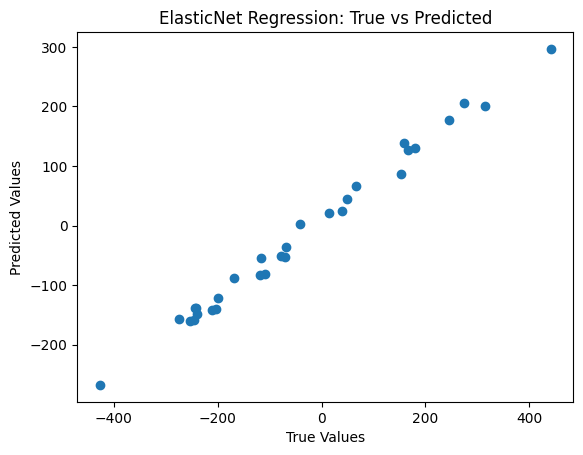

In [ ]:

### Example: ElasticNet Regression in Python

import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# Create synthetic regression data
X, y = make_regression(n_samples=100, n_features=10, noise=0.3, random_state=420)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the ElasticNet model (alpha=1.0, l1_ratio=0.5 for a mix of L1 and L2 penalties)
## notice sklearns' elasticnet hyperparams are l1_ratio (alpha in the explanation above) and alpha (lambda above)
model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Fit the model
model.fit(X_train, y_train)

# Predict using the model
y_pred = model.predict(X_test)

# Evaluate the model (using R-squared)
score = model.score(X_test, y_test)
print(f"R-squared: {score}")

# Plotting true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('ElasticNet Regression: True vs Predicted');


---

### Let us work with a classic (toy) dataset available from sklearn: Diabetes

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# Load dataset
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target  # Add target variable

# Place features in X, target in y
X = diabetes.data
y = diabetes.target  # Add target column

# Pairplot with hue based on target (binned into 2 categories for visualization)
#df['target_bin'] = pd.qcut(df['target'], q=2, labels=['Low', 'High'])  # Bin target
#sns.pairplot(df, hue='target_bin', diag_kind='kde');

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardization (important for linear regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print final shapes
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (397, 10) (397,)
Test shape: (45, 10) (45,)


In [25]:
from sklearn.linear_model import ElasticNet
from scipy.stats import uniform
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
from pprint import pprint
import time

## let us set up the values for the hyperparameters for ElasticNet
param_grid = {
    'alpha': np.geomspace(0.001, 10, num=20),
    'l1_ratio': np.linspace(0, 1, num=10, endpoint=True)
}
nr_combinations = len(param_grid['alpha']) * len(param_grid['l1_ratio'])
nr_combinations_random = nr_combinations // 2
nr_combinations_optuna = nr_combinations // 3

elastic_net = ElasticNet()
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='r2')
start_time = time.time()
grid_search.fit(X_train, y_train)
seconds_grid = time.time() - start_time

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# compute test metric.
final_model = ElasticNet(**grid_search.best_params_)
final_model.fit(X_train, y_train)
test_score = final_model.score(X_test, y_test)
train_score = final_model.score(X_train, y_train)

# put it in data frame for compilation of results
res_df = pd.DataFrame([('grid search', nr_combinations, train_score, grid_search.best_score_, test_score, seconds_grid, grid_search.best_params_['alpha'], grid_search.best_params_['l1_ratio'])], 
                      columns=['strategy', 'nr. combinations tried', 'train score', 'cv score', 'test score', 
                               'seconds', 'best alpha', 'best l1_ratio'])
res_df.round(3).head()


Best parameters: {'alpha': 0.001623776739188721, 'l1_ratio': 0.0}
Best cross-validation score: 0.4581603621426944


,strategy,nr. combinations tried,train score,cv score,test score,seconds,best alpha,best l1_ratio
0,grid search,200,0.512,0.458,0.552,2.361,0.002,0.0


In [26]:

param_distributions = {
    'alpha': uniform(0.001, 10),  # Uniformly sample alpha from 0.001 to 10
    'l1_ratio': uniform(0, 1)  # Uniformly sample l1_ratio from 0 to 1
}

elastic_net = ElasticNet()
random_search = RandomizedSearchCV(elastic_net, param_distributions, n_iter=nr_combinations_random, cv=5, scoring='r2', random_state=42)
start_time = time.time()
random_search.fit(X_train, y_train)
seconds_random = time.time() - start_time

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# compute test metric.
final_model = ElasticNet(**random_search.best_params_)
final_model.fit(X_train, y_train)
test_score = final_model.score(X_test, y_test)
train_score = final_model.score(X_train, y_train)

# put it in data frame for compilation of results
res_df.loc[len(res_df)] = ('random search', len(random_search.cv_results_['params']), train_score, random_search.best_score_, test_score, 
                           seconds_random, random_search.best_params_['alpha'], random_search.best_params_['l1_ratio'])
res_df.round(3).sort_values(by='test score', ascending=False)


Best parameters: {'alpha': 0.05622117123602399, 'l1_ratio': 0.8154614284548342}
Best cross-validation score: 0.4572747353672879


,strategy,nr. combinations tried,train score,cv score,test score,seconds,best alpha,best l1_ratio
1,random search,100,0.511,0.457,0.553,1.159,0.056,0.815
0,grid search,200,0.512,0.458,0.552,2.361,0.002,0.000


### let us look at more sophisticated options.. (optuna, for instance)

In [27]:
import optuna
import logging
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(logging.WARNING) ## suppress info logs from optuna

def objective(trial):
    # Hyperparameter search space
    alpha = trial.suggest_float('alpha', 0.001, 10, log=True)  # Regularization strength
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)  # Mix between L1 (Lasso) and L2 (Ridge)

    # Define the ElasticNet model with a pipeline that includes feature scaling
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    # Evaluate using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    return np.mean(scores)

# Create an Optuna study and optimize
study = optuna.create_study(direction="maximize")
start_time = time.time()
study.optimize(objective, n_trials=nr_combinations_optuna)
seconds_optuna = time.time() - start_time

# Best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best score (R2):", study.best_value)

# compute test metric.
final_model = ElasticNet(**study.best_params)
final_model.fit(X_train, y_train)
test_score = final_model.score(X_test, y_test)
train_score = final_model.score(X_train, y_train)

# put it in data frame for compilation of results
res_df.loc[len(res_df)] = ('optuna search', len(study.trials), train_score, study.best_value, test_score, 
                           seconds_optuna, study.best_params['alpha'], study.best_params['l1_ratio'])
res_df.round(3).sort_values(by='test score', ascending=False)


Best hyperparameters: {'alpha': 0.0016411252465524636, 'l1_ratio': 0.07838342785948721}
Best score (R2): 0.45816029181361034


,strategy,nr. combinations tried,train score,cv score,test score,seconds,best alpha,best l1_ratio
1,random search,100,0.511,0.457,0.553,1.159,0.056,0.815
0,grid search,200,0.512,0.458,0.552,2.361,0.002,0.000
2,optuna search,66,0.512,0.458,0.552,1.860,0.002,0.078


### Compare values tried ..

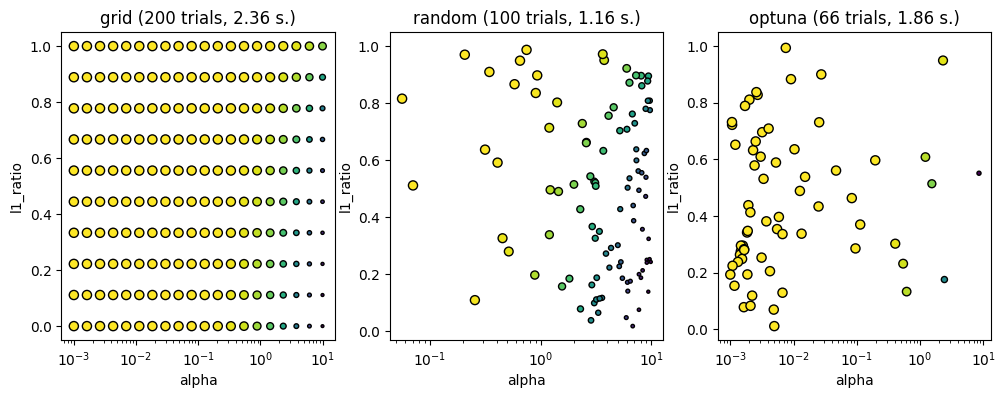

In [28]:
## let us compare combinations tried in both cases..


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

grid_combinations = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
alphas = [d['alpha'] for d in grid_combinations]
l1s = [d['l1_ratio'] for d in grid_combinations]
axes[0].scatter(alphas, l1s, c=scores, cmap='viridis', s=(scores+1)**10, edgecolors='black')
axes[0].set_title(f'grid ({len(scores)} trials, {seconds_grid:.2f} s.)')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('l1_ratio')
axes[0].semilogx(True)

random_combinations = random_search.cv_results_['params']
scores = random_search.cv_results_['mean_test_score']
alphas = [d['alpha'] for d in random_combinations]
l1s = [d['l1_ratio'] for d in random_combinations]
axes[1].scatter(alphas, l1s, c=scores, cmap='viridis', s=(scores+1)**10, edgecolors='black')
axes[1].set_title(f'random ({len(scores)} trials, {seconds_random:.2f} s.)')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('l1_ratio')
axes[1].semilogx(True)

scores = np.array([trial.value for trial in study.trials])
alphas = np.array([trial.params['alpha'] for trial in study.trials])
l1s = np.array([trial.params['l1_ratio'] for trial in study.trials])
axes[2].scatter(alphas, l1s, c=scores, cmap='viridis', s=(scores+1)**10, edgecolors='black')
axes[2].set_title(f'optuna ({len(scores)} trials, {seconds_optuna:.2f} s.)')
axes[2].set_xlabel('alpha')
axes[2].set_ylabel('l1_ratio')
axes[2].semilogx(True);




## Exercises for you: implement any (or both) of the missing strategies 

- [ ] explore hyperopt (https://hyperopt.github.io/hyperopt/) package for hyperparameter value search, compare with the above
- [ ] explore other cross-val options for comparing values